Positional Encoding
================================

We loose positional information when using self-attention, as compared to RNNs with cross-attention. The idea of positional encoding is to capture the position information and use that to augument the input vectors.

Three key requirements of positional encoding vectors:
- The values need to be bounded.
- Each position should have its own vector. The same position should have the same values.
- They need to be unique. No two positions should share the same encoding vectors.
- The euclidean distance between two vectors needs to reflect the positional distance between the correponding two position indices. Take position `3` for example, the vector distance between position `1` and `3`, needs to be the same as `3` and `5`, as both `1` and `5` are two positions away from `3`.


## Helper Files
Download these files and place them in the same directory as the current notebook before you start. 

In [58]:
from IPython.display import FileLink, FileLinks

In [60]:
FileLink('plots_transformer.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\plots_transformer.py

In [61]:
FileLink('util.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\util.py

In [62]:
FileLink('replay.py')

c:\Users\wei\jupyter_book\cits4012\cits4012_natural_language_processing\cits4012_natural_language_processing\transformer\replay.py

## Imports

In [34]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from util import StepByStep
from plots_transformer import *

## Angular Speed

### Fixed Based Positional Encoding

Visualisation of base 4, 5 and 7. Each base corresponds to an angular speed of ($\frac{360}{4}$,$\frac{360}{5}$,$\frac{360}{7}$) per position, indicating how many degrees to move along the circle at each position. For example, at position 3, the corresponding degrees to move for each base is $\frac{360}{4} *3$,$\frac{360}{5} *3 $,$\frac{360}{7} * 3$, respectively. We use sine and cosine of these degrees along a unit circle to get the position encodings. The values under each position index is a vector encode the position.

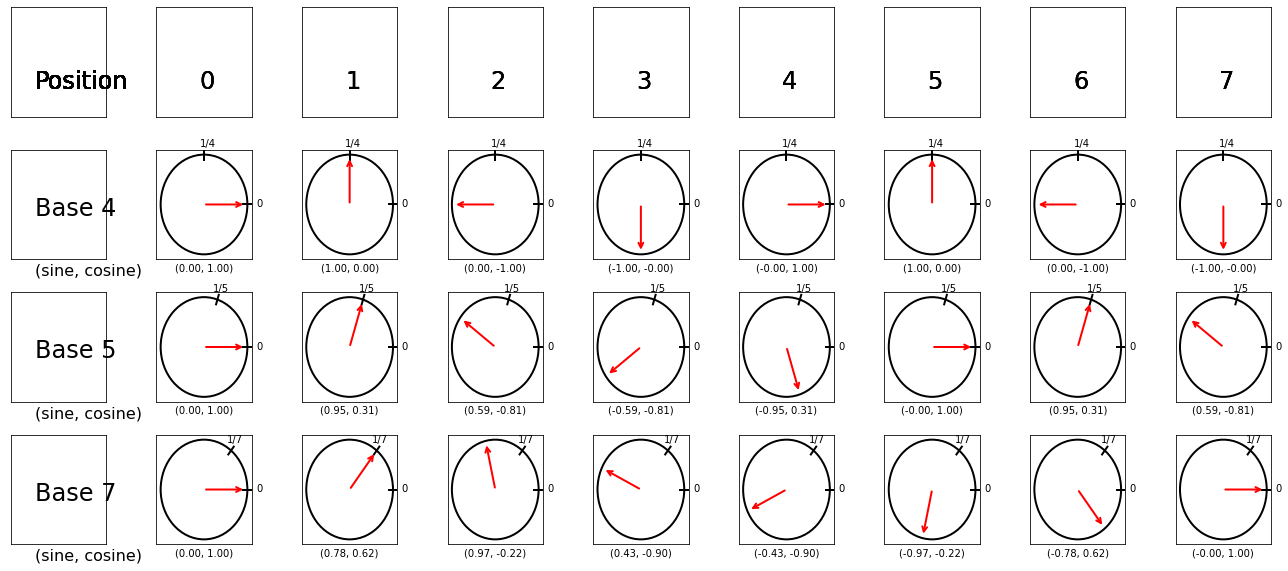

In [4]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

![](../images/posenc_modnorm_sincos.png)

![](../images/sincos_distance.png)

As shown above the position encoding above meets the requirements we listed above. 

:::{admonition} Your Turn
Implement a position encoding using the above bases (4,5,7), and verify the distance between positions is maintained by the positional encodings.
:::

### General Exponential Bases

In real implementation, we do not need to worry about choosing the right bases.

As the first vector, we can simply move along the circle as many radians as the index of the position (one radian is approximately $\frac{360}{2\pi}=57.3$
degrees). Then, for each new vector we add to the encoding, we move along the
circle with exponentially slower angular speeds. For example, in the second
vector, we would move only one-tenth of a radian (approximately 5.73 degrees)
for each new position. In the third vector we would move only one-hundredth of a
radian, and so on and so forth. Figure below depicts the red arrow moving at
increasingly slower angular speeds, for an eight dimensional positional encoding. For eight dimensions, we need four speeds and to get the four speeds, we can use the exponential power of 10000 like below to get speed multipliers (in this case, $[1, 0.1, 0.01, 0.001]$). 
$$
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

$$
PE_{pos,\ 2d} = sin \left(\frac{1}{10000^{\frac{2d}{d_{model}}}}pos\right); 
$$
$$
PE_{pos,\ 2d+1} = cos \left(\frac{1}{10000^{\frac{2d}{d_{model}}}}pos\right)
$$

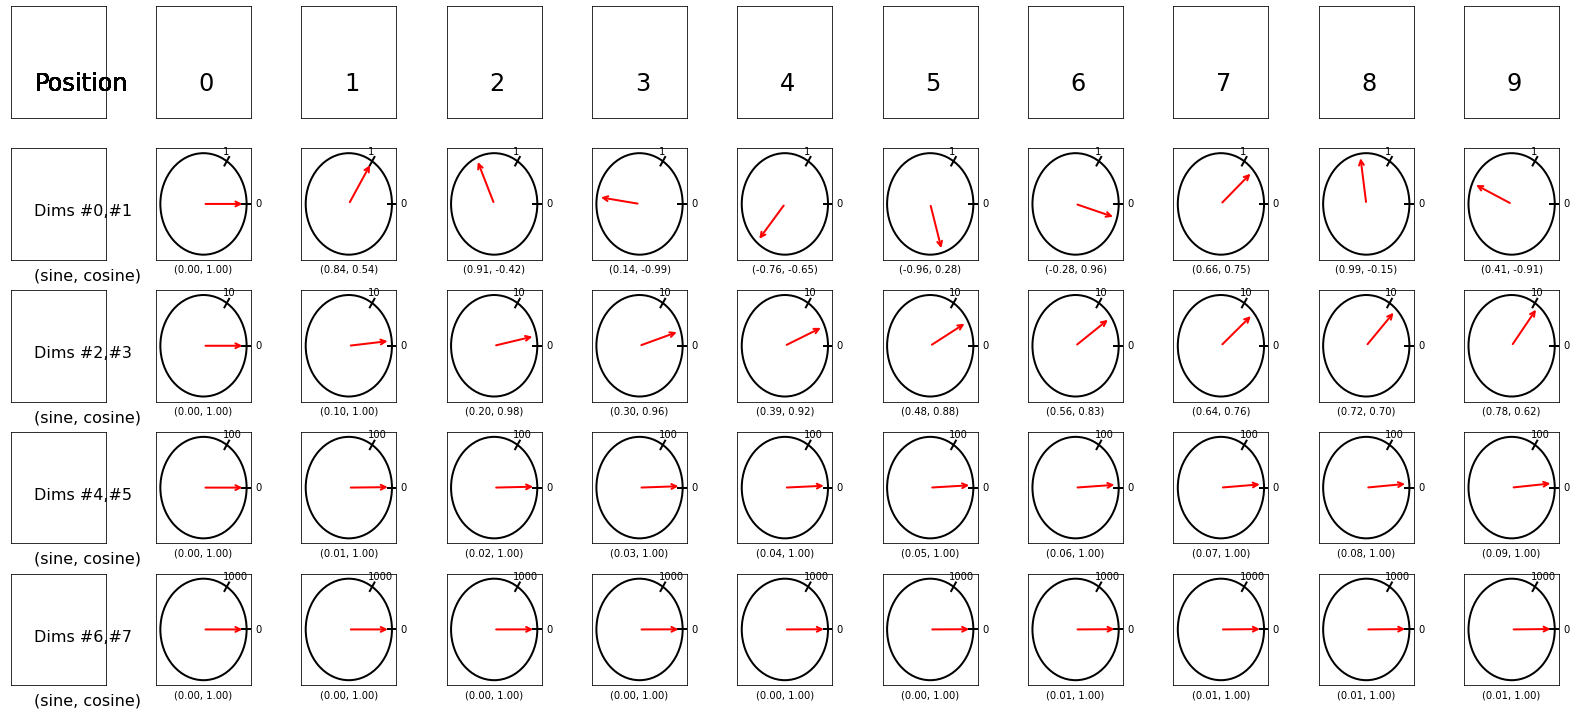

In [5]:
fig = exponential_dials(d_model=8, max_len=10)

In [9]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

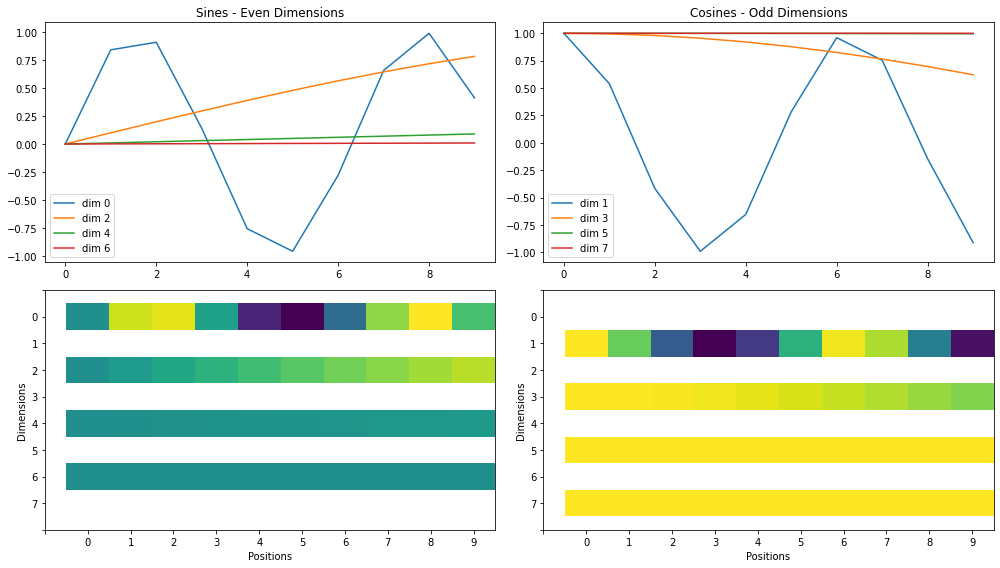

In [10]:
fig = encoding_heatmap(d_model=8, max_len=10)

In [11]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

### A Note on Encoded Distances

We have already seen:
- the encoded distance is defined by the Euclidean distance between two
vectors or, in other words, it is the norm (size) of the difference between
two encoding vectors
- the encoded distance between positions zero and two (T=2) should be
exactly the same as the encoded distance between positions one and
three, two and four, and so on

In other words, the encoded distance between any two positions T steps
apart remains constant. Let's illustrate this by computing the encoded
distances among the first five positions (by the way, we are using the
encoding with eight dimensions.)

In [12]:
distances = np.zeros((5, 5))
for i, v1 in enumerate(encoding[:5]):
    for j, v2 in enumerate(encoding[:5]):
        distances[i, j] = np.linalg.norm(v1 - v2)

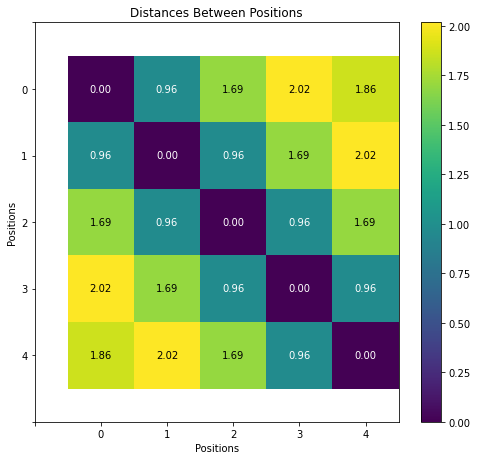

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

## The positional encoding class

There is a couple of things about this class to highlight:
- in the constructor, it uses `register_buffer` to define an attribute of the module
- in the forward method, it is scaling the input before adding the positional
encoding

### `register_buffer`

:::{important} `register_buffer`
The `register_buffer` is used to define an attribute that is part of the module's
state, yet not a parameter. In other words, it is the recorded in `state_dict` but is not updated or tracked by the dynamic computational graph for gradient calculation.
:::

The positional encoding is a good example: its values
are computed according to the dimension and length used by the model, and even
though these values are going to be used during training, they shouldn not be updated
by gradient descent.

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

### Reverse Input Scaling

:::{warning} "crowded-out" effect
As shown below, the original coordinates are "crowded-out" by the addition of
the positional encoding (especially the first row). This may happen if the data
points have values roughly in the same range as the positional encoding.
:::

Unfortunately, this is fairly common: both standardized inputs and word
embeddings are likely to have most of their values inside the `[-1, 1]` range of the positional encoding.

:::{note} "How can we handle "crowded-out"?"
The scaling in the forward method "reverses the standardization" of the inputs (using a standard deviation equals the square root of their dimensionality) to retrieve the hypothetical "raw" inputs.
:::

$$
\text{standardized}\ x = \frac{\text{``raw"}\ x}{\sqrt{d_x}} \implies \text{``raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In [16]:
posenc = PositionalEncoding(2, 2)

In [17]:
list(posenc.parameters()), posenc.state_dict()

([],
 OrderedDict([('pe', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

In [18]:
posenc.pe

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

In [20]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [21]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [22]:
source_seq + posenc.pe

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

In [23]:
posenc(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

The results above (after the encoding) illustrate the effect of scaling the inputs: it seems to have lessened the crowding-out effect of the positional encoding. 

:::{warning} Reverse standardisation is bad for the model, when the input dimension is large

For inputs with many dimensions, the effect of reverse standardisation will be much more pronounced: a 300-dimensions embedding will have a scaling factor around 17, for example. Another normalization trick: [layer normalization](https://weiliu2k.github.io/CITS4012/transformer/LayerNorm.html), will counter-act it. 
:::

## Encoder and Decoder with Self Attention

These are the same code we have seen earlier in the Week 12 lab. 

In [35]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None
                
    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys
                
    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores
            
    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()
        
        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

In [25]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model, 
                                                   input_dim=input_dim, 
                                                   proj_values=proj_values) 
                                         for _ in range(n_heads)])
        
    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)
        
    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)
        
    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out
        
    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

In [26]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )
         
    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

In [27]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )
        
    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)
         
    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

## Encoder + Decoder + PE

The new encoder and decoder classes are just wrapping their self-attention
counterparts by assigning the latter as the layer attribute (`self.layer`) of the former, and encoding the inputs prior to calling the corresponding layer in the `forward()` method:


In [28]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)
    
    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out
    
class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)
        
    def init_keys(self, states):
        self.layer.init_keys(states)
    
    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

In [30]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)
        
    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask
                
    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)
        
    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq, 
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs
    
    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs
                
    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)
            
        return outputs

## Data Preparation

In [37]:
def generate_sequences(n=128, variable_len=False, seed=13):
    basic_corners = np.array([[-1, -1], [-1, 1], [1, 1], [1, -1]])
    np.random.seed(seed)
    bases = np.random.randint(4, size=n)
    if variable_len:
        lengths = np.random.randint(3, size=n) + 2
    else:
        lengths = [4] * n
    directions = np.random.randint(2, size=n)
    points = [basic_corners[[(b + i) % 4 for i in range(4)]][slice(None, None, d*2-1)][:l] + np.random.randn(l, 2) * 0.1 for b, d, l in zip(bases, directions, lengths)]
    return points, directions

In [38]:
points, directions = generate_sequences()
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

In [39]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [40]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

## Model Configuration & Training

In [41]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [42]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

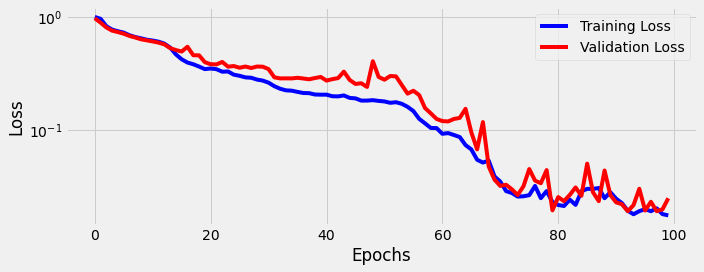

In [43]:
fig = sbs_seq_selfattnpe.plot_losses()

## Visualizing Results

### Visualizing Predictions

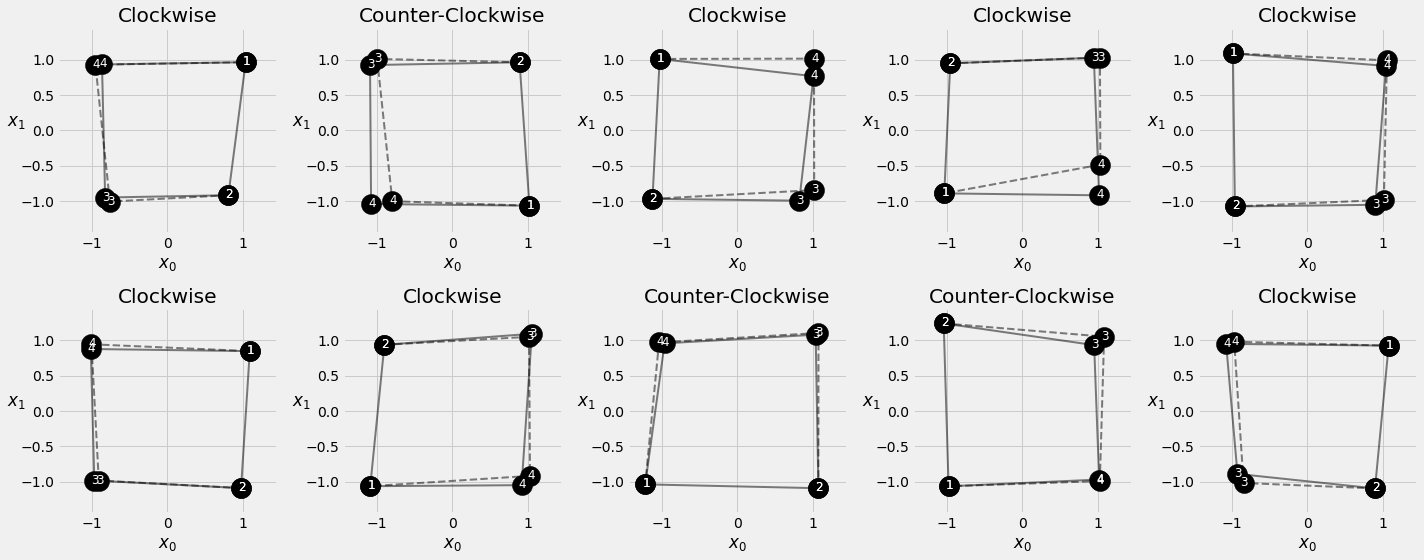

In [44]:
fig = sequence_pred(sbs_seq_selfattnpe, full_test, test_directions)

### Visualizing Attention

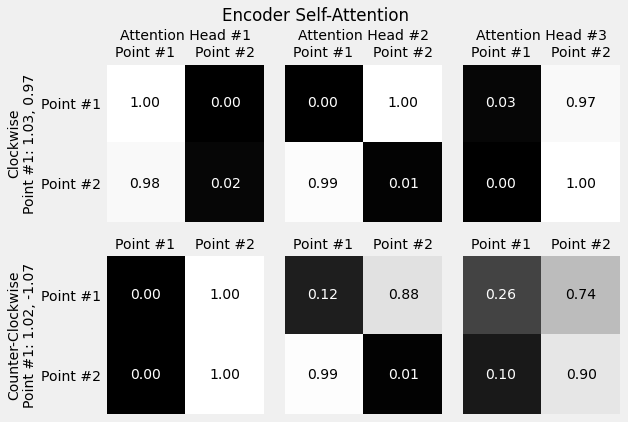

In [46]:
inputs = full_test[:2, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, decoder=False, self_attn=True, alphas_attr='encoder.layer.self_attn_heads.alphas')
fig.suptitle('Encoder Self-Attention')
fig.subplots_adjust(top=0.85) 

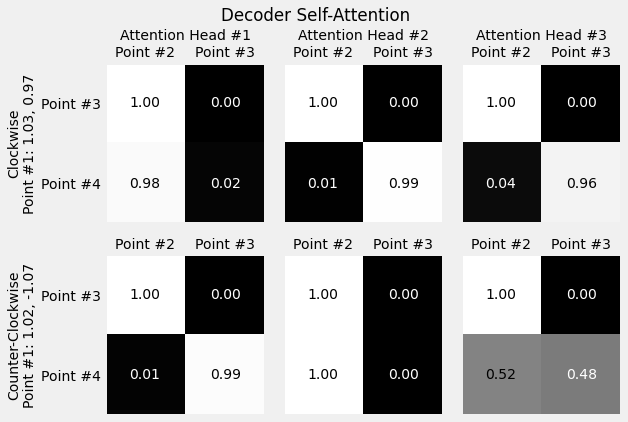

In [47]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, 
                     decoder=True, self_attn=True, alphas_attr='decoder.layer.self_attn_heads.alphas')
fig.suptitle('Decoder Self-Attention')
fig.subplots_adjust(top=0.85) 

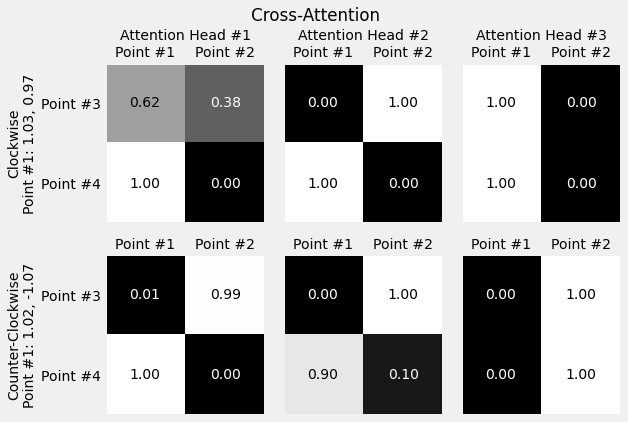

In [48]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, self_attn=False, alphas_attr='decoder.layer.cross_attn_heads.alphas')
fig.suptitle('Cross-Attention')
fig.subplots_adjust(top=0.85) 